In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm
import math
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor()]) #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

batch_size = 4

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

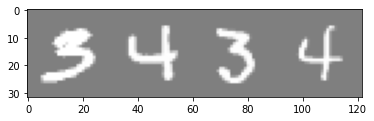

3 4 3 4


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
images, labels = next(iter(trainloader))

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{labels[j]}' for j in range(batch_size)))

In [4]:
images.size()
# 28, 28 images
# Into a conv 
test_conv = nn.Conv2d(1, 3, 3)
test_pool = nn.MaxPool2d(3,3)
out = F.relu(test_pool(test_conv(images)))
images.size(), out.size()


(torch.Size([4, 1, 28, 28]), torch.Size([4, 3, 8, 8]))

In [5]:
"""
X: 1, 28, 28
CONV: co, 26, 26
Pool: co, 8, 8
FF: co*64 -> 10

"""

class CNN(nn.Module):
    def __init__(self, scale, dropout=0):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        channels_out = int(scale * 3)
        self.width = channels_out * 64
        self.conv1 = nn.Conv2d(1, channels_out, 3)
        self.pool = nn.MaxPool2d(3,3)
        self.ff1 = nn.Linear(self.width, 10)
    
    def forward(self, x):
        out = F.relu(self.pool(self.conv1(x)))
        out = out.view(-1, self.width)
        out = self.dropout(out)
        return self.ff1(out) 

In [33]:
model = CNN(1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [34]:

model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
running_loss = 0
pbar = tqdm(enumerate(trainloader), total=len(trainloader))
for i, (images, labels) in pbar:
    optimizer.zero_grad()
    images = images.to(device)    
    labels = labels.to(device)


    logits = model(images)
    loss = loss_fn(logits, labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
    if i % 500 == 0:    # print every 2000 mini-batches
        pbar.set_description(f'[{i:5d}] loss: {running_loss / 500:.3f}')
        running_loss = 0.0

[14500] loss: 0.267: 100%|██████████| 15000/15000 [00:18<00:00, 797.76it/s]


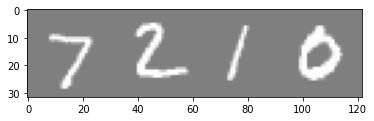

Labels 		7 2 1 0
Predictions 	7 2 1 0


In [35]:
def test_model(model):
    images, labels = next(iter(testloader))
    images = images.to(device)
    label = labels.to(device)
    # show images
    imshow(torchvision.utils.make_grid(images).detach().cpu())
    # print labels
    labels_string = ' '.join(f'{labels[j]}' for j in range(batch_size))
    print(f'Labels \t\t{labels_string}')
    preds_string = ' '.join(f'{l.item()}' for l in model(images).argmax(dim=-1))
    print(f'Predictions \t{preds_string}')
test_model(model)

In [37]:
running_loss = 0
pbar = tqdm(enumerate(testloader), total=len(testloader))
for i, (images, labels) in pbar:
    images = images.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        logits = model(images)
        loss = loss_fn(logits, labels)
    
    running_loss += loss.item()
    if i > 0 and i % 500 == 0:
        pbar.set_description(f'[{i:5d}] loss: {running_loss / i:.3f}')

running_loss

[ 2000] loss: 0.263: 100%|██████████| 2500/2500 [00:01<00:00, 1553.25it/s]


611.8500768863014

In [24]:
torch.utils.data.random_split(trainloader, [len(trainloader)//2, len(trainloader) - len(trainloader)//2], generator=torch.Generator().manual_seed(42))[0]

In [47]:
def train_and_test_model(model_scale, dataset_prop, dropout=0):
    model = CNN(model_scale, dropout)
    model.to(device)
    
    loss_fn = nn.CrossEntropyLoss()
    fan_in = nn.init._calculate_fan_in_and_fan_out(model.conv1.weight)[0]
    lr = 0.01/math.sqrt(fan_in)
    
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    
    
    subset_size = math.floor(len(trainset) * dataset_prop)
    trainset_subset = torch.utils.data.random_split(trainset, [subset_size, len(trainset) - subset_size], generator=torch.Generator().manual_seed(42))[0]
    trainloader_subset = torch.utils.data.DataLoader(trainset_subset, batch_size=batch_size,
                                          shuffle=True)
    
    #TRAIN
    print(f"Training model with scale {model_scale:.2f}, dataset size {dataset_prop:.2f}")
    running_loss = 0
    pbar = tqdm(enumerate(trainloader_subset), total=len(trainloader_subset))
    for i, (images, labels) in pbar:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()

        logits = model(images)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 500 == 0:    # print every 2000 mini-batches
            pbar.set_description(f'[{i:5d}] loss: {running_loss / 500:.3f}')
            running_loss = 0.0
    
    #TEST
    print(f"Testing model with scale {model_scale:.2f}, dataset size {dataset_prop:.2f}")
    running_loss = 0
    running_accuracy = 0
    pbar = tqdm(enumerate(testloader), total=len(testloader))
    for i, (images, labels) in pbar:
        images = images.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            logits = model(images)
            loss = loss_fn(logits, labels)
    
        running_accuracy += (logits.argmax(-1) == labels).all().item()
        running_loss += loss.item()
        if i > 0 and i % 500 == 0:
            pbar.set_description(f'[{i:5d}] loss: {running_loss / i:.3f} accuracy: {running_accuracy *100 / i:.2f}%')
    return running_loss / len(testloader), running_accuracy / len(testloader)


#train_and_test_model(16, 0.5)

In [40]:
plt.scatter(compute_used, model_loss)
plt.xscale("log")
plt.xlabel("compute used")
plt.yscale("log")
plt.ylabel("Total test loss")
plt.show()

NameError: name 'compute_used' is not defined

In [ ]:
model_loss_dataset = []
dataset_size = []
accuracy_dataset = []
model_loss_params = []
compute_used = []
accuracy_params = []

for i in range(-2, 5):
    print(f'{i + 2}/7')
    model_scale = 2 ** (i/2)
    dataset_scale = 2 ** -i
    
    model_loss_par = 0
    accuracy_par = 0
    compute = model_scale ** 2
    
    model_loss_data = 0
    accuracy_data = 0
    data_size = dataset_scale
    
    for j in range(0,5): 
        loss, accuracy = train_and_test_model(model_scale, 1)
        accuracy_par += accuracy
        model_loss_par += loss
        loss, accuracy = train_and_test_model(1, dataset_scale)
        accuracy_data += accuracy
        model_loss_data += loss
    
    
    model_loss_params.append(model_loss_par / 5)
    accuracy_params.append(accuracy_par / 5)
    compute_used.append(model_scale ** 2)
        
    model_loss_dataset.append(model_loss_data / 5)
    accuracy_dataset.append(accuracy_data / 5)
    dataset_size.append(data_size)

0/7
Training model with scale 0.50, dataset size 1.00


[14500] loss: 0.387: 100%|██████████| 15000/15000 [00:16<00:00, 893.92it/s]


Testing model with scale 0.50, dataset size 1.00


[ 2000] loss: 0.369 accuracy: 64.35%: 100%|██████████| 2500/2500 [00:01<00:00, 1652.59it/s]


Training model with scale 1.00, dataset size 4.00


[14500] loss: 0.144: 100%|██████████| 15000/15000 [00:18<00:00, 806.48it/s]


Testing model with scale 1.00, dataset size 4.00


[ 2000] loss: 0.171 accuracy: 80.90%: 100%|██████████| 2500/2500 [00:01<00:00, 1509.78it/s]


Training model with scale 0.50, dataset size 1.00


[14500] loss: 0.370: 100%|██████████| 15000/15000 [00:16<00:00, 909.10it/s]


Testing model with scale 0.50, dataset size 1.00


[ 2000] loss: 0.428 accuracy: 58.70%: 100%|██████████| 2500/2500 [00:01<00:00, 1633.09it/s]


Training model with scale 1.00, dataset size 4.00


[14500] loss: 0.268: 100%|██████████| 15000/15000 [00:18<00:00, 803.40it/s]


Testing model with scale 1.00, dataset size 4.00


[ 2000] loss: 0.231 accuracy: 75.80%: 100%|██████████| 2500/2500 [00:01<00:00, 1526.41it/s]


Training model with scale 0.50, dataset size 1.00


[14500] loss: 2.302: 100%|██████████| 15000/15000 [00:16<00:00, 889.89it/s]


Testing model with scale 0.50, dataset size 1.00


[ 2000] loss: 2.307 accuracy: 0.00%: 100%|██████████| 2500/2500 [00:01<00:00, 1615.77it/s]


Training model with scale 1.00, dataset size 4.00


[14500] loss: 0.138: 100%|██████████| 15000/15000 [00:18<00:00, 801.83it/s]


Testing model with scale 1.00, dataset size 4.00


[ 2000] loss: 0.136 accuracy: 84.45%: 100%|██████████| 2500/2500 [00:01<00:00, 1496.78it/s]


Training model with scale 0.50, dataset size 1.00


[14500] loss: 0.419: 100%|██████████| 15000/15000 [00:16<00:00, 899.61it/s]


Testing model with scale 0.50, dataset size 1.00


[ 2000] loss: 0.381 accuracy: 62.20%: 100%|██████████| 2500/2500 [00:01<00:00, 1671.27it/s]


Training model with scale 1.00, dataset size 4.00


[14500] loss: 0.156: 100%|██████████| 15000/15000 [00:18<00:00, 806.68it/s]


Testing model with scale 1.00, dataset size 4.00


[ 2000] loss: 0.161 accuracy: 81.35%: 100%|██████████| 2500/2500 [00:01<00:00, 1519.44it/s]


Training model with scale 0.50, dataset size 1.00


[14500] loss: 0.398: 100%|██████████| 15000/15000 [00:16<00:00, 910.30it/s]


Testing model with scale 0.50, dataset size 1.00


[ 2000] loss: 0.375 accuracy: 62.25%: 100%|██████████| 2500/2500 [00:01<00:00, 1615.21it/s]


Training model with scale 1.00, dataset size 4.00


[14500] loss: 0.157: 100%|██████████| 15000/15000 [00:18<00:00, 798.27it/s]


Testing model with scale 1.00, dataset size 4.00


[ 2000] loss: 0.135 accuracy: 84.15%: 100%|██████████| 2500/2500 [00:01<00:00, 1514.74it/s]


1/7
Training model with scale 0.71, dataset size 1.00


[14500] loss: 0.244: 100%|██████████| 15000/15000 [00:16<00:00, 883.29it/s]


Testing model with scale 0.71, dataset size 1.00


[ 2000] loss: 0.211 accuracy: 76.55%: 100%|██████████| 2500/2500 [00:01<00:00, 1623.52it/s]


Training model with scale 1.00, dataset size 2.00


[14500] loss: 0.216: 100%|██████████| 15000/15000 [00:18<00:00, 794.98it/s]


Testing model with scale 1.00, dataset size 2.00


[ 2000] loss: 0.180 accuracy: 79.80%: 100%|██████████| 2500/2500 [00:01<00:00, 1454.03it/s]


Training model with scale 0.71, dataset size 1.00


[14500] loss: 0.418: 100%|██████████| 15000/15000 [00:16<00:00, 886.42it/s]


Testing model with scale 0.71, dataset size 1.00


[ 2000] loss: 0.414 accuracy: 60.20%: 100%|██████████| 2500/2500 [00:01<00:00, 1624.83it/s]


Training model with scale 1.00, dataset size 2.00


[14500] loss: 0.313: 100%|██████████| 15000/15000 [00:18<00:00, 790.73it/s]


Testing model with scale 1.00, dataset size 2.00


[ 2000] loss: 0.299 accuracy: 70.00%: 100%|██████████| 2500/2500 [00:01<00:00, 1465.55it/s]


Training model with scale 0.71, dataset size 1.00


[14500] loss: 0.257: 100%|██████████| 15000/15000 [00:17<00:00, 878.92it/s]


Testing model with scale 0.71, dataset size 1.00


[ 2000] loss: 0.220 accuracy: 77.05%: 100%|██████████| 2500/2500 [00:01<00:00, 1632.49it/s]


Training model with scale 1.00, dataset size 2.00


[14500] loss: 0.112: 100%|██████████| 15000/15000 [00:18<00:00, 791.84it/s]


Testing model with scale 1.00, dataset size 2.00


[ 2000] loss: 0.161 accuracy: 81.00%: 100%|██████████| 2500/2500 [00:01<00:00, 1492.67it/s]


Training model with scale 0.71, dataset size 1.00


[14500] loss: 0.368: 100%|██████████| 15000/15000 [00:16<00:00, 896.26it/s]


Testing model with scale 0.71, dataset size 1.00


[ 2000] loss: 0.386 accuracy: 64.05%: 100%|██████████| 2500/2500 [00:01<00:00, 1671.39it/s]


Training model with scale 1.00, dataset size 2.00


[14500] loss: 0.157: 100%|██████████| 15000/15000 [00:18<00:00, 803.44it/s]


Testing model with scale 1.00, dataset size 2.00


[ 2000] loss: 0.151 accuracy: 82.35%: 100%|██████████| 2500/2500 [00:01<00:00, 1418.57it/s]


Training model with scale 0.71, dataset size 1.00


[14500] loss: 0.191: 100%|██████████| 15000/15000 [00:16<00:00, 893.34it/s]


Testing model with scale 0.71, dataset size 1.00


[ 2000] loss: 0.194 accuracy: 78.40%: 100%|██████████| 2500/2500 [00:01<00:00, 1547.73it/s]


Training model with scale 1.00, dataset size 2.00


[14500] loss: 0.163: 100%|██████████| 15000/15000 [00:18<00:00, 807.84it/s]


Testing model with scale 1.00, dataset size 2.00


[ 2000] loss: 0.144 accuracy: 83.60%: 100%|██████████| 2500/2500 [00:01<00:00, 1493.23it/s]


2/7
Training model with scale 1.00, dataset size 1.00


[14500] loss: 0.132: 100%|██████████| 15000/15000 [00:18<00:00, 794.50it/s]


Testing model with scale 1.00, dataset size 1.00


[ 2000] loss: 0.140 accuracy: 84.05%: 100%|██████████| 2500/2500 [00:01<00:00, 1467.73it/s]


Training model with scale 1.00, dataset size 1.00


[14500] loss: 0.218: 100%|██████████| 15000/15000 [00:18<00:00, 811.68it/s]


Testing model with scale 1.00, dataset size 1.00


[ 2000] loss: 0.185 accuracy: 80.30%: 100%|██████████| 2500/2500 [00:01<00:00, 1465.65it/s]


Training model with scale 1.00, dataset size 1.00


[14500] loss: 0.221: 100%|██████████| 15000/15000 [00:18<00:00, 810.27it/s]


Testing model with scale 1.00, dataset size 1.00


[ 2000] loss: 0.226 accuracy: 75.20%: 100%|██████████| 2500/2500 [00:01<00:00, 1460.30it/s]


Training model with scale 1.00, dataset size 1.00


[14500] loss: 0.168: 100%|██████████| 15000/15000 [00:18<00:00, 792.84it/s]


Testing model with scale 1.00, dataset size 1.00


[ 2000] loss: 0.173 accuracy: 81.90%: 100%|██████████| 2500/2500 [00:01<00:00, 1461.73it/s]


Training model with scale 1.00, dataset size 1.00


[14500] loss: 0.122: 100%|██████████| 15000/15000 [00:18<00:00, 812.58it/s]


Testing model with scale 1.00, dataset size 1.00


[ 2000] loss: 0.147 accuracy: 83.40%: 100%|██████████| 2500/2500 [00:01<00:00, 1491.26it/s]


Training model with scale 1.00, dataset size 1.00


[14500] loss: 0.214: 100%|██████████| 15000/15000 [00:18<00:00, 810.35it/s]


Testing model with scale 1.00, dataset size 1.00


[ 2000] loss: 0.210 accuracy: 78.00%: 100%|██████████| 2500/2500 [00:01<00:00, 1502.95it/s]


Training model with scale 1.00, dataset size 1.00


[14500] loss: 0.152: 100%|██████████| 15000/15000 [00:18<00:00, 816.67it/s]


Testing model with scale 1.00, dataset size 1.00


[ 2000] loss: 0.159 accuracy: 80.65%: 100%|██████████| 2500/2500 [00:01<00:00, 1423.33it/s]


Training model with scale 1.00, dataset size 1.00


[14500] loss: 0.160: 100%|██████████| 15000/15000 [00:18<00:00, 791.22it/s]


Testing model with scale 1.00, dataset size 1.00


[ 2000] loss: 0.167 accuracy: 79.85%: 100%|██████████| 2500/2500 [00:01<00:00, 1488.69it/s]


Training model with scale 1.00, dataset size 1.00


[14500] loss: 0.183: 100%|██████████| 15000/15000 [00:18<00:00, 811.44it/s]


Testing model with scale 1.00, dataset size 1.00


[ 2000] loss: 0.195 accuracy: 78.35%: 100%|██████████| 2500/2500 [00:01<00:00, 1471.20it/s]


Training model with scale 1.00, dataset size 1.00


[14500] loss: 0.245: 100%|██████████| 15000/15000 [00:18<00:00, 805.21it/s]


Testing model with scale 1.00, dataset size 1.00


[ 2000] loss: 0.202 accuracy: 77.15%: 100%|██████████| 2500/2500 [00:01<00:00, 1468.27it/s]


3/7
Training model with scale 1.41, dataset size 1.00


[14500] loss: 0.200: 100%|██████████| 15000/15000 [00:18<00:00, 814.36it/s]


Testing model with scale 1.41, dataset size 1.00


[ 2000] loss: 0.153 accuracy: 83.00%: 100%|██████████| 2500/2500 [00:01<00:00, 1506.39it/s]


Training model with scale 1.00, dataset size 0.50


[ 7000] loss: 0.222: 100%|██████████| 7500/7500 [00:09<00:00, 811.42it/s]


Testing model with scale 1.00, dataset size 0.50


[ 2000] loss: 0.198 accuracy: 77.90%: 100%|██████████| 2500/2500 [00:01<00:00, 1477.62it/s]


Training model with scale 1.41, dataset size 1.00


[14500] loss: 0.140: 100%|██████████| 15000/15000 [00:18<00:00, 811.85it/s]


Testing model with scale 1.41, dataset size 1.00


[ 2000] loss: 0.123 accuracy: 86.35%: 100%|██████████| 2500/2500 [00:01<00:00, 1514.40it/s]


Training model with scale 1.00, dataset size 0.50


[ 7000] loss: 0.215: 100%|██████████| 7500/7500 [00:09<00:00, 833.21it/s]


Testing model with scale 1.00, dataset size 0.50


[ 2000] loss: 0.203 accuracy: 78.55%: 100%|██████████| 2500/2500 [00:01<00:00, 1435.85it/s]


Training model with scale 1.41, dataset size 1.00


[14500] loss: 0.168: 100%|██████████| 15000/15000 [00:18<00:00, 811.67it/s]


Testing model with scale 1.41, dataset size 1.00


[ 2000] loss: 0.124 accuracy: 86.05%: 100%|██████████| 2500/2500 [00:01<00:00, 1460.57it/s]


Training model with scale 1.00, dataset size 0.50


[ 7000] loss: 0.217: 100%|██████████| 7500/7500 [00:09<00:00, 808.11it/s]


Testing model with scale 1.00, dataset size 0.50


[ 2000] loss: 0.186 accuracy: 80.15%: 100%|██████████| 2500/2500 [00:01<00:00, 1478.54it/s]


Training model with scale 1.41, dataset size 1.00


[14500] loss: 0.153: 100%|██████████| 15000/15000 [00:18<00:00, 804.65it/s]


Testing model with scale 1.41, dataset size 1.00


[ 2000] loss: 0.119 accuracy: 85.70%: 100%|██████████| 2500/2500 [00:01<00:00, 1491.14it/s]


Training model with scale 1.00, dataset size 0.50


[ 7000] loss: 0.210: 100%|██████████| 7500/7500 [00:09<00:00, 798.22it/s]


Testing model with scale 1.00, dataset size 0.50


[ 2000] loss: 0.253 accuracy: 73.65%: 100%|██████████| 2500/2500 [00:01<00:00, 1449.49it/s]


Training model with scale 1.41, dataset size 1.00


[14500] loss: 0.128: 100%|██████████| 15000/15000 [00:18<00:00, 809.16it/s]


Testing model with scale 1.41, dataset size 1.00


[ 2000] loss: 0.136 accuracy: 84.35%: 100%|██████████| 2500/2500 [00:01<00:00, 1482.46it/s]


Training model with scale 1.00, dataset size 0.50


[ 7000] loss: 0.163: 100%|██████████| 7500/7500 [00:09<00:00, 799.43it/s]


Testing model with scale 1.00, dataset size 0.50


[ 2000] loss: 0.186 accuracy: 79.80%: 100%|██████████| 2500/2500 [00:01<00:00, 1488.12it/s]


4/7
Training model with scale 2.00, dataset size 1.00


[14500] loss: 0.096: 100%|██████████| 15000/15000 [00:18<00:00, 799.49it/s]


Testing model with scale 2.00, dataset size 1.00


[ 2000] loss: 0.099 accuracy: 88.40%: 100%|██████████| 2500/2500 [00:01<00:00, 1447.41it/s]


Training model with scale 1.00, dataset size 0.25


[ 3500] loss: 0.359: 100%|██████████| 3750/3750 [00:04<00:00, 793.04it/s]


Testing model with scale 1.00, dataset size 0.25


[ 2000] loss: 0.350 accuracy: 64.50%: 100%|██████████| 2500/2500 [00:01<00:00, 1505.15it/s]


Training model with scale 2.00, dataset size 1.00


[14500] loss: 0.124: 100%|██████████| 15000/15000 [00:18<00:00, 798.13it/s]


Testing model with scale 2.00, dataset size 1.00


[ 2000] loss: 0.095 accuracy: 88.75%: 100%|██████████| 2500/2500 [00:01<00:00, 1486.76it/s]


Training model with scale 1.00, dataset size 0.25


[ 3500] loss: 0.301: 100%|██████████| 3750/3750 [00:04<00:00, 811.56it/s]


Testing model with scale 1.00, dataset size 0.25


[ 2000] loss: 0.266 accuracy: 71.60%: 100%|██████████| 2500/2500 [00:01<00:00, 1448.54it/s]


Training model with scale 2.00, dataset size 1.00


[14500] loss: 0.121: 100%|██████████| 15000/15000 [00:18<00:00, 826.70it/s]


Testing model with scale 2.00, dataset size 1.00


[ 2000] loss: 0.099 accuracy: 88.30%: 100%|██████████| 2500/2500 [00:01<00:00, 1546.76it/s]


Training model with scale 1.00, dataset size 0.25


[ 3500] loss: 0.500: 100%|██████████| 3750/3750 [00:04<00:00, 817.53it/s]


Testing model with scale 1.00, dataset size 0.25


[ 2000] loss: 0.461 accuracy: 55.05%: 100%|██████████| 2500/2500 [00:01<00:00, 1478.31it/s]


Training model with scale 2.00, dataset size 1.00


[14500] loss: 0.140: 100%|██████████| 15000/15000 [00:18<00:00, 814.21it/s]


Testing model with scale 2.00, dataset size 1.00


[ 2000] loss: 0.116 accuracy: 87.30%: 100%|██████████| 2500/2500 [00:01<00:00, 1469.82it/s]


Training model with scale 1.00, dataset size 0.25


[ 3500] loss: 0.295: 100%|██████████| 3750/3750 [00:04<00:00, 813.11it/s]


Testing model with scale 1.00, dataset size 0.25


[ 2000] loss: 0.245 accuracy: 73.85%: 100%|██████████| 2500/2500 [00:01<00:00, 1503.09it/s]


Training model with scale 2.00, dataset size 1.00


[14500] loss: 0.117: 100%|██████████| 15000/15000 [00:18<00:00, 794.22it/s]


Testing model with scale 2.00, dataset size 1.00


[ 2000] loss: 0.115 accuracy: 86.25%: 100%|██████████| 2500/2500 [00:01<00:00, 1467.79it/s]


Training model with scale 1.00, dataset size 0.25


[ 3500] loss: 0.322: 100%|██████████| 3750/3750 [00:04<00:00, 797.43it/s]


Testing model with scale 1.00, dataset size 0.25


[ 2000] loss: 0.264 accuracy: 72.60%: 100%|██████████| 2500/2500 [00:01<00:00, 1430.58it/s]


5/7
Training model with scale 2.83, dataset size 1.00


[14500] loss: 0.132: 100%|██████████| 15000/15000 [00:18<00:00, 809.57it/s]


Testing model with scale 2.83, dataset size 1.00


[ 2000] loss: 0.129 accuracy: 85.10%: 100%|██████████| 2500/2500 [00:01<00:00, 1471.14it/s]


Training model with scale 1.00, dataset size 0.12


[ 1500] loss: 0.452: 100%|██████████| 1875/1875 [00:02<00:00, 794.83it/s]


Testing model with scale 1.00, dataset size 0.12


[ 2000] loss: 0.386 accuracy: 62.70%: 100%|██████████| 2500/2500 [00:01<00:00, 1516.13it/s]


Training model with scale 2.83, dataset size 1.00


[14500] loss: 0.113: 100%|██████████| 15000/15000 [00:18<00:00, 812.58it/s]


Testing model with scale 2.83, dataset size 1.00


[ 2000] loss: 0.113 accuracy: 86.25%: 100%|██████████| 2500/2500 [00:01<00:00, 1496.89it/s]


Training model with scale 1.00, dataset size 0.12


[ 1500] loss: 0.343: 100%|██████████| 1875/1875 [00:02<00:00, 812.58it/s]


Testing model with scale 1.00, dataset size 0.12


[ 2000] loss: 0.316 accuracy: 66.10%: 100%|██████████| 2500/2500 [00:01<00:00, 1451.36it/s]


Training model with scale 2.83, dataset size 1.00


[14500] loss: 0.110: 100%|██████████| 15000/15000 [00:18<00:00, 816.43it/s]


Testing model with scale 2.83, dataset size 1.00


[ 2000] loss: 0.108 accuracy: 86.85%: 100%|██████████| 2500/2500 [00:01<00:00, 1480.24it/s]


Training model with scale 1.00, dataset size 0.12


[ 1500] loss: 0.439: 100%|██████████| 1875/1875 [00:02<00:00, 813.57it/s]


Testing model with scale 1.00, dataset size 0.12


[ 2000] loss: 0.418 accuracy: 58.15%: 100%|██████████| 2500/2500 [00:01<00:00, 1460.32it/s]


Training model with scale 2.83, dataset size 1.00


[14500] loss: 0.111: 100%|██████████| 15000/15000 [00:18<00:00, 811.87it/s]


Testing model with scale 2.83, dataset size 1.00


[ 2000] loss: 0.096 accuracy: 88.50%: 100%|██████████| 2500/2500 [00:01<00:00, 1468.42it/s]


Training model with scale 1.00, dataset size 0.12


[ 1500] loss: 0.415: 100%|██████████| 1875/1875 [00:02<00:00, 804.74it/s]


Testing model with scale 1.00, dataset size 0.12


[  500] loss: 0.371 accuracy: 63.20%:  30%|███       | 752/2500 [00:00<00:01, 1489.23it/s]

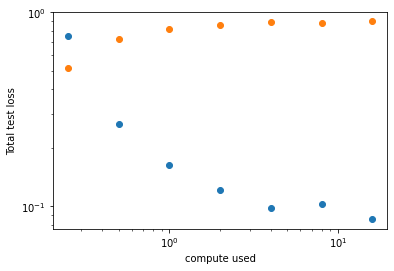

In [42]:
plt.scatter(compute_used, model_loss_params)
plt.scatter(compute_used, accuracy_params)

plt.xscale("log")
plt.xlabel("compute used")
plt.yscale("log")
plt.ylabel("Total test loss")
plt.show()

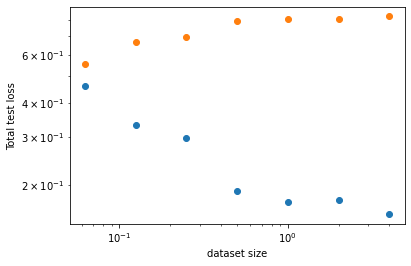

In [44]:
plt.scatter(dataset_size, model_loss_dataset)
plt.scatter(dataset_size, accuracy_dataset)

plt.xscale("log")
plt.xlabel("dataset size")
plt.yscale("log")
plt.ylabel("Total test loss")
plt.show()

In [48]:
d_model_loss_dataset = []
d_dataset_size = []
d_accuracy_dataset = []
d_model_loss_params = []
d_compute_used = []
d_accuracy_params = []

for i in range(-2, 5):
    print(f'{i + 2}/7')
    model_scale = 2 ** (i/2)
    dataset_scale = 2 ** -i
    
    model_loss_par = 0
    accuracy_par = 0
    compute = model_scale ** 2
    
    model_loss_data = 0
    accuracy_data = 0
    data_size = dataset_scale
    
    for j in range(0,5): 
        loss, accuracy = train_and_test_model(model_scale, 1, 0.2)
        accuracy_par += accuracy
        model_loss_par += loss
        loss, accuracy = train_and_test_model(1, dataset_scale, 0.2)
        accuracy_data += accuracy
        model_loss_data += loss
    
    
    d_model_loss_params.append(model_loss_par / 5)
    d_accuracy_params.append(accuracy_par / 5)
    d_compute_used.append(model_scale ** 2)
        
    d_model_loss_dataset.append(model_loss_data / 5)
    d_accuracy_dataset.append(accuracy_data / 5)
    d_dataset_size.append(data_size)

0/7
Training model with scale 0.50, dataset size 1.00


[14500] loss: 0.592: 100%|██████████| 15000/15000 [00:17<00:00, 864.61it/s]


Testing model with scale 0.50, dataset size 1.00


[ 2000] loss: 0.540 accuracy: 48.50%: 100%|██████████| 2500/2500 [00:01<00:00, 1616.81it/s]


Training model with scale 1.00, dataset size 4.00


[14500] loss: 0.206: 100%|██████████| 15000/15000 [00:19<00:00, 784.76it/s]


Testing model with scale 1.00, dataset size 4.00


[ 2000] loss: 0.226 accuracy: 74.20%: 100%|██████████| 2500/2500 [00:01<00:00, 1396.26it/s]


Training model with scale 0.50, dataset size 1.00


[14500] loss: 0.614: 100%|██████████| 15000/15000 [00:17<00:00, 866.95it/s]


Testing model with scale 0.50, dataset size 1.00


[ 2000] loss: 0.644 accuracy: 41.60%: 100%|██████████| 2500/2500 [00:01<00:00, 1507.31it/s]


Training model with scale 1.00, dataset size 4.00


[14500] loss: 0.304: 100%|██████████| 15000/15000 [00:19<00:00, 779.17it/s]


Testing model with scale 1.00, dataset size 4.00


[ 2000] loss: 0.252 accuracy: 73.65%: 100%|██████████| 2500/2500 [00:01<00:00, 1439.76it/s]


Training model with scale 0.50, dataset size 1.00


[14500] loss: 0.702: 100%|██████████| 15000/15000 [00:17<00:00, 866.73it/s]


Testing model with scale 0.50, dataset size 1.00


[ 2000] loss: 0.670 accuracy: 38.95%: 100%|██████████| 2500/2500 [00:01<00:00, 1571.58it/s]


Training model with scale 1.00, dataset size 4.00


[14500] loss: 0.270: 100%|██████████| 15000/15000 [00:19<00:00, 789.05it/s]


Testing model with scale 1.00, dataset size 4.00


[ 2000] loss: 0.243 accuracy: 73.25%: 100%|██████████| 2500/2500 [00:01<00:00, 1442.92it/s]


Training model with scale 0.50, dataset size 1.00


[14500] loss: 0.755: 100%|██████████| 15000/15000 [00:17<00:00, 876.24it/s]


Testing model with scale 0.50, dataset size 1.00


[ 2000] loss: 0.706 accuracy: 36.95%: 100%|██████████| 2500/2500 [00:01<00:00, 1581.80it/s]


Training model with scale 1.00, dataset size 4.00


[14500] loss: 0.235: 100%|██████████| 15000/15000 [00:18<00:00, 797.69it/s]


Testing model with scale 1.00, dataset size 4.00


[ 2000] loss: 0.217 accuracy: 76.55%: 100%|██████████| 2500/2500 [00:01<00:00, 1426.56it/s]


Training model with scale 0.50, dataset size 1.00


[14500] loss: 2.304: 100%|██████████| 15000/15000 [00:17<00:00, 860.77it/s]


Testing model with scale 0.50, dataset size 1.00


[ 2000] loss: 2.304 accuracy: 0.00%: 100%|██████████| 2500/2500 [00:01<00:00, 1563.76it/s]


Training model with scale 1.00, dataset size 4.00


[14500] loss: 0.272: 100%|██████████| 15000/15000 [00:19<00:00, 773.96it/s]


Testing model with scale 1.00, dataset size 4.00


[ 2000] loss: 0.238 accuracy: 73.70%: 100%|██████████| 2500/2500 [00:01<00:00, 1382.78it/s]


1/7
Training model with scale 0.71, dataset size 1.00


[14500] loss: 0.654: 100%|██████████| 15000/15000 [00:17<00:00, 842.68it/s]


Testing model with scale 0.71, dataset size 1.00


[ 2000] loss: 0.709 accuracy: 38.20%: 100%|██████████| 2500/2500 [00:01<00:00, 1604.79it/s]


Training model with scale 1.00, dataset size 2.00


[14500] loss: 0.271: 100%|██████████| 15000/15000 [00:18<00:00, 790.73it/s]


Testing model with scale 1.00, dataset size 2.00


[ 2000] loss: 0.245 accuracy: 73.20%: 100%|██████████| 2500/2500 [00:01<00:00, 1401.33it/s]


Training model with scale 0.71, dataset size 1.00


[14500] loss: 0.466: 100%|██████████| 15000/15000 [00:17<00:00, 881.78it/s]


Testing model with scale 0.71, dataset size 1.00


[ 2000] loss: 0.437 accuracy: 55.50%: 100%|██████████| 2500/2500 [00:01<00:00, 1596.15it/s]


Training model with scale 1.00, dataset size 2.00


[14500] loss: 0.234: 100%|██████████| 15000/15000 [00:18<00:00, 804.09it/s]


Testing model with scale 1.00, dataset size 2.00


[ 2000] loss: 0.230 accuracy: 75.00%: 100%|██████████| 2500/2500 [00:01<00:00, 1448.07it/s]


Training model with scale 0.71, dataset size 1.00


[14500] loss: 0.378: 100%|██████████| 15000/15000 [00:17<00:00, 877.95it/s]


Testing model with scale 0.71, dataset size 1.00


[ 2000] loss: 0.382 accuracy: 61.40%: 100%|██████████| 2500/2500 [00:01<00:00, 1592.32it/s]


Training model with scale 1.00, dataset size 2.00


[14500] loss: 0.275: 100%|██████████| 15000/15000 [00:18<00:00, 793.58it/s]


Testing model with scale 1.00, dataset size 2.00


[ 2000] loss: 0.249 accuracy: 73.25%: 100%|██████████| 2500/2500 [00:01<00:00, 1429.78it/s]


Training model with scale 0.71, dataset size 1.00


[14500] loss: 0.297: 100%|██████████| 15000/15000 [00:17<00:00, 876.21it/s]


Testing model with scale 0.71, dataset size 1.00


[ 2000] loss: 0.307 accuracy: 67.55%: 100%|██████████| 2500/2500 [00:01<00:00, 1588.09it/s]


Training model with scale 1.00, dataset size 2.00


[14500] loss: 0.253: 100%|██████████| 15000/15000 [00:18<00:00, 796.19it/s]


Testing model with scale 1.00, dataset size 2.00


[ 2000] loss: 0.234 accuracy: 74.20%: 100%|██████████| 2500/2500 [00:01<00:00, 1437.09it/s]


Training model with scale 0.71, dataset size 1.00


[14500] loss: 0.334: 100%|██████████| 15000/15000 [00:17<00:00, 862.52it/s]


Testing model with scale 0.71, dataset size 1.00


[ 2000] loss: 0.333 accuracy: 64.25%: 100%|██████████| 2500/2500 [00:01<00:00, 1603.80it/s]


Training model with scale 1.00, dataset size 2.00


[14500] loss: 0.248: 100%|██████████| 15000/15000 [00:18<00:00, 791.37it/s]


Testing model with scale 1.00, dataset size 2.00


[ 2000] loss: 0.232 accuracy: 75.40%: 100%|██████████| 2500/2500 [00:01<00:00, 1487.73it/s]


2/7
Training model with scale 1.00, dataset size 1.00


[14500] loss: 0.281: 100%|██████████| 15000/15000 [00:19<00:00, 773.06it/s]


Testing model with scale 1.00, dataset size 1.00


[ 2000] loss: 0.258 accuracy: 73.00%: 100%|██████████| 2500/2500 [00:01<00:00, 1471.38it/s]


Training model with scale 1.00, dataset size 1.00


[14500] loss: 0.544: 100%|██████████| 15000/15000 [00:19<00:00, 783.96it/s]


Testing model with scale 1.00, dataset size 1.00


[ 2000] loss: 0.541 accuracy: 49.35%: 100%|██████████| 2500/2500 [00:01<00:00, 1450.07it/s]


Training model with scale 1.00, dataset size 1.00


[14500] loss: 0.338: 100%|██████████| 15000/15000 [00:19<00:00, 782.34it/s]


Testing model with scale 1.00, dataset size 1.00


[ 2000] loss: 0.337 accuracy: 65.10%: 100%|██████████| 2500/2500 [00:01<00:00, 1420.85it/s]


Training model with scale 1.00, dataset size 1.00


[14500] loss: 0.244: 100%|██████████| 15000/15000 [00:19<00:00, 783.30it/s]


Testing model with scale 1.00, dataset size 1.00


[ 2000] loss: 0.243 accuracy: 73.10%: 100%|██████████| 2500/2500 [00:01<00:00, 1476.14it/s]


Training model with scale 1.00, dataset size 1.00


[14500] loss: 0.225: 100%|██████████| 15000/15000 [00:18<00:00, 791.53it/s]


Testing model with scale 1.00, dataset size 1.00


[ 2000] loss: 0.254 accuracy: 73.15%: 100%|██████████| 2500/2500 [00:01<00:00, 1444.78it/s]


Training model with scale 1.00, dataset size 1.00


[14500] loss: 0.397: 100%|██████████| 15000/15000 [00:19<00:00, 784.79it/s]


Testing model with scale 1.00, dataset size 1.00


[ 2000] loss: 0.393 accuracy: 59.95%: 100%|██████████| 2500/2500 [00:01<00:00, 1413.54it/s]


Training model with scale 1.00, dataset size 1.00


[14500] loss: 0.356: 100%|██████████| 15000/15000 [00:19<00:00, 785.18it/s]


Testing model with scale 1.00, dataset size 1.00


[ 2000] loss: 0.376 accuracy: 61.80%: 100%|██████████| 2500/2500 [00:01<00:00, 1450.47it/s]


Training model with scale 1.00, dataset size 1.00


[14500] loss: 0.225: 100%|██████████| 15000/15000 [00:19<00:00, 776.11it/s]


Testing model with scale 1.00, dataset size 1.00


[ 2000] loss: 0.245 accuracy: 73.50%: 100%|██████████| 2500/2500 [00:01<00:00, 1407.15it/s]


Training model with scale 1.00, dataset size 1.00


[14500] loss: 0.347: 100%|██████████| 15000/15000 [00:19<00:00, 779.15it/s]


Testing model with scale 1.00, dataset size 1.00


[ 2000] loss: 0.397 accuracy: 59.00%: 100%|██████████| 2500/2500 [00:01<00:00, 1483.86it/s]


Training model with scale 1.00, dataset size 1.00


[14500] loss: 0.243: 100%|██████████| 15000/15000 [00:19<00:00, 781.76it/s]


Testing model with scale 1.00, dataset size 1.00


[ 2000] loss: 0.230 accuracy: 74.80%: 100%|██████████| 2500/2500 [00:01<00:00, 1399.13it/s]


3/7
Training model with scale 1.41, dataset size 1.00


[14500] loss: 0.192: 100%|██████████| 15000/15000 [00:18<00:00, 789.93it/s]


Testing model with scale 1.41, dataset size 1.00


[ 2000] loss: 0.193 accuracy: 78.70%: 100%|██████████| 2500/2500 [00:01<00:00, 1433.60it/s]


Training model with scale 1.00, dataset size 0.50


[ 7000] loss: 0.480: 100%|██████████| 7500/7500 [00:09<00:00, 775.08it/s]


Testing model with scale 1.00, dataset size 0.50


[ 2000] loss: 0.472 accuracy: 53.30%: 100%|██████████| 2500/2500 [00:01<00:00, 1457.32it/s]


Training model with scale 1.41, dataset size 1.00


[14500] loss: 0.212: 100%|██████████| 15000/15000 [00:19<00:00, 788.83it/s]


Testing model with scale 1.41, dataset size 1.00


[ 2000] loss: 0.218 accuracy: 75.15%: 100%|██████████| 2500/2500 [00:01<00:00, 1489.15it/s]


Training model with scale 1.00, dataset size 0.50


[ 7000] loss: 0.289: 100%|██████████| 7500/7500 [00:09<00:00, 780.90it/s]


Testing model with scale 1.00, dataset size 0.50


[ 2000] loss: 0.286 accuracy: 70.90%: 100%|██████████| 2500/2500 [00:01<00:00, 1433.79it/s]


Training model with scale 1.41, dataset size 1.00


[14500] loss: 0.300: 100%|██████████| 15000/15000 [00:19<00:00, 788.19it/s]


Testing model with scale 1.41, dataset size 1.00


[ 2000] loss: 0.251 accuracy: 71.05%: 100%|██████████| 2500/2500 [00:01<00:00, 1442.96it/s]


Training model with scale 1.00, dataset size 0.50


[ 7000] loss: 0.347: 100%|██████████| 7500/7500 [00:09<00:00, 794.97it/s]


Testing model with scale 1.00, dataset size 0.50


[ 2000] loss: 0.322 accuracy: 66.75%: 100%|██████████| 2500/2500 [00:01<00:00, 1472.19it/s]


Training model with scale 1.41, dataset size 1.00


[14500] loss: 0.215: 100%|██████████| 15000/15000 [00:19<00:00, 784.93it/s]


Testing model with scale 1.41, dataset size 1.00


[ 2000] loss: 0.198 accuracy: 77.00%: 100%|██████████| 2500/2500 [00:01<00:00, 1458.65it/s]


Training model with scale 1.00, dataset size 0.50


[ 7000] loss: 0.280: 100%|██████████| 7500/7500 [00:09<00:00, 772.26it/s]


Testing model with scale 1.00, dataset size 0.50


[ 2000] loss: 0.273 accuracy: 71.50%: 100%|██████████| 2500/2500 [00:01<00:00, 1474.23it/s]


Training model with scale 1.41, dataset size 1.00


[14500] loss: 0.209: 100%|██████████| 15000/15000 [00:19<00:00, 777.87it/s]


Testing model with scale 1.41, dataset size 1.00


[ 2000] loss: 0.206 accuracy: 77.50%: 100%|██████████| 2500/2500 [00:01<00:00, 1428.02it/s]


Training model with scale 1.00, dataset size 0.50


[ 7000] loss: 0.241: 100%|██████████| 7500/7500 [00:09<00:00, 778.40it/s]


Testing model with scale 1.00, dataset size 0.50


[ 2000] loss: 0.245 accuracy: 75.55%: 100%|██████████| 2500/2500 [00:01<00:00, 1441.33it/s]


4/7
Training model with scale 2.00, dataset size 1.00


[14500] loss: 0.137: 100%|██████████| 15000/15000 [00:19<00:00, 772.31it/s]


Testing model with scale 2.00, dataset size 1.00


[ 2000] loss: 0.160 accuracy: 81.35%: 100%|██████████| 2500/2500 [00:01<00:00, 1410.99it/s]


Training model with scale 1.00, dataset size 0.25


[ 3500] loss: 0.386: 100%|██████████| 3750/3750 [00:04<00:00, 785.24it/s]


Testing model with scale 1.00, dataset size 0.25


[ 2000] loss: 0.380 accuracy: 59.85%: 100%|██████████| 2500/2500 [00:01<00:00, 1492.68it/s]


Training model with scale 2.00, dataset size 1.00


[14500] loss: 0.174: 100%|██████████| 15000/15000 [00:19<00:00, 780.10it/s]


Testing model with scale 2.00, dataset size 1.00


[ 2000] loss: 0.160 accuracy: 81.85%: 100%|██████████| 2500/2500 [00:01<00:00, 1426.40it/s]


Training model with scale 1.00, dataset size 0.25


[ 3500] loss: 0.354: 100%|██████████| 3750/3750 [00:04<00:00, 818.12it/s]


Testing model with scale 1.00, dataset size 0.25


[ 2000] loss: 0.332 accuracy: 65.85%: 100%|██████████| 2500/2500 [00:01<00:00, 1488.91it/s]


Training model with scale 2.00, dataset size 1.00


[14500] loss: 0.147: 100%|██████████| 15000/15000 [00:19<00:00, 786.55it/s]


Testing model with scale 2.00, dataset size 1.00


[ 2000] loss: 0.150 accuracy: 81.85%: 100%|██████████| 2500/2500 [00:01<00:00, 1417.47it/s]


Training model with scale 1.00, dataset size 0.25


[ 3500] loss: 0.353: 100%|██████████| 3750/3750 [00:04<00:00, 778.06it/s]


Testing model with scale 1.00, dataset size 0.25


[ 2000] loss: 0.332 accuracy: 65.95%: 100%|██████████| 2500/2500 [00:01<00:00, 1477.44it/s]


Training model with scale 2.00, dataset size 1.00


[14500] loss: 0.209: 100%|██████████| 15000/15000 [00:19<00:00, 788.95it/s]


Testing model with scale 2.00, dataset size 1.00


[ 2000] loss: 0.202 accuracy: 76.65%: 100%|██████████| 2500/2500 [00:01<00:00, 1487.75it/s]


Training model with scale 1.00, dataset size 0.25


[ 3500] loss: 0.607: 100%|██████████| 3750/3750 [00:04<00:00, 780.79it/s]


Testing model with scale 1.00, dataset size 0.25


[ 2000] loss: 0.591 accuracy: 42.15%: 100%|██████████| 2500/2500 [00:01<00:00, 1450.01it/s]


Training model with scale 2.00, dataset size 1.00


[14500] loss: 0.150: 100%|██████████| 15000/15000 [00:18<00:00, 793.81it/s]


Testing model with scale 2.00, dataset size 1.00


[ 2000] loss: 0.153 accuracy: 82.65%: 100%|██████████| 2500/2500 [00:01<00:00, 1509.59it/s]


Training model with scale 1.00, dataset size 0.25


[ 3500] loss: 0.327: 100%|██████████| 3750/3750 [00:04<00:00, 816.05it/s]


Testing model with scale 1.00, dataset size 0.25


[ 2000] loss: 0.345 accuracy: 64.00%: 100%|██████████| 2500/2500 [00:01<00:00, 1446.71it/s]


5/7
Training model with scale 2.83, dataset size 1.00


[14500] loss: 0.144: 100%|██████████| 15000/15000 [00:19<00:00, 778.71it/s]


Testing model with scale 2.83, dataset size 1.00


[ 2000] loss: 0.130 accuracy: 84.65%: 100%|██████████| 2500/2500 [00:01<00:00, 1489.17it/s]


Training model with scale 1.00, dataset size 0.12


[ 1500] loss: 0.466: 100%|██████████| 1875/1875 [00:02<00:00, 753.02it/s]


Testing model with scale 1.00, dataset size 0.12


[ 2000] loss: 0.393 accuracy: 60.60%: 100%|██████████| 2500/2500 [00:01<00:00, 1430.71it/s]


Training model with scale 2.83, dataset size 1.00


[14500] loss: 0.120: 100%|██████████| 15000/15000 [00:19<00:00, 785.22it/s]


Testing model with scale 2.83, dataset size 1.00


[ 2000] loss: 0.145 accuracy: 83.40%: 100%|██████████| 2500/2500 [00:01<00:00, 1493.53it/s]


Training model with scale 1.00, dataset size 0.12


[ 1500] loss: 0.565: 100%|██████████| 1875/1875 [00:02<00:00, 782.29it/s]


Testing model with scale 1.00, dataset size 0.12


[ 2000] loss: 0.432 accuracy: 57.55%: 100%|██████████| 2500/2500 [00:01<00:00, 1464.97it/s]


Training model with scale 2.83, dataset size 1.00


[14500] loss: 0.146: 100%|██████████| 15000/15000 [00:19<00:00, 778.78it/s]


Testing model with scale 2.83, dataset size 1.00


[ 2000] loss: 0.151 accuracy: 81.65%: 100%|██████████| 2500/2500 [00:01<00:00, 1455.27it/s]


Training model with scale 1.00, dataset size 0.12


[ 1500] loss: 0.672: 100%|██████████| 1875/1875 [00:02<00:00, 787.66it/s]


Testing model with scale 1.00, dataset size 0.12


[ 2000] loss: 0.526 accuracy: 50.10%: 100%|██████████| 2500/2500 [00:01<00:00, 1439.06it/s]


Training model with scale 2.83, dataset size 1.00


[14500] loss: 0.130: 100%|██████████| 15000/15000 [00:18<00:00, 799.64it/s]


Testing model with scale 2.83, dataset size 1.00


[ 2000] loss: 0.136 accuracy: 84.45%: 100%|██████████| 2500/2500 [00:01<00:00, 1458.91it/s]


Training model with scale 1.00, dataset size 0.12


[ 1500] loss: 0.501: 100%|██████████| 1875/1875 [00:02<00:00, 754.42it/s]


Testing model with scale 1.00, dataset size 0.12


[ 2000] loss: 0.395 accuracy: 58.00%: 100%|██████████| 2500/2500 [00:01<00:00, 1419.25it/s]


Training model with scale 2.83, dataset size 1.00


[14500] loss: 0.167: 100%|██████████| 15000/15000 [00:18<00:00, 800.13it/s]


Testing model with scale 2.83, dataset size 1.00


[ 2000] loss: 0.162 accuracy: 81.45%: 100%|██████████| 2500/2500 [00:01<00:00, 1466.89it/s]


Training model with scale 1.00, dataset size 0.12


[ 1500] loss: 0.471: 100%|██████████| 1875/1875 [00:02<00:00, 760.19it/s]


Testing model with scale 1.00, dataset size 0.12


[ 2000] loss: 0.368 accuracy: 64.35%: 100%|██████████| 2500/2500 [00:01<00:00, 1464.81it/s]


6/7
Training model with scale 4.00, dataset size 1.00


[14500] loss: 0.134: 100%|██████████| 15000/15000 [00:18<00:00, 793.45it/s]


Testing model with scale 4.00, dataset size 1.00


[ 2000] loss: 0.110 accuracy: 87.60%: 100%|██████████| 2500/2500 [00:01<00:00, 1443.52it/s]


Training model with scale 1.00, dataset size 0.06


[  500] loss: 1.344: 100%|██████████| 938/938 [00:01<00:00, 766.70it/s]


Testing model with scale 1.00, dataset size 0.06


[ 2000] loss: 0.619 accuracy: 43.55%: 100%|██████████| 2500/2500 [00:01<00:00, 1412.32it/s]


Training model with scale 4.00, dataset size 1.00


[14500] loss: 0.125: 100%|██████████| 15000/15000 [00:19<00:00, 788.01it/s]


Testing model with scale 4.00, dataset size 1.00


[ 2000] loss: 0.123 accuracy: 85.75%: 100%|██████████| 2500/2500 [00:01<00:00, 1480.92it/s]


Training model with scale 1.00, dataset size 0.06


[  500] loss: 1.118: 100%|██████████| 938/938 [00:01<00:00, 763.93it/s]


Testing model with scale 1.00, dataset size 0.06


[ 2000] loss: 0.627 accuracy: 41.75%: 100%|██████████| 2500/2500 [00:01<00:00, 1444.73it/s]


Training model with scale 4.00, dataset size 1.00


[14500] loss: 0.156: 100%|██████████| 15000/15000 [00:18<00:00, 798.96it/s]


Testing model with scale 4.00, dataset size 1.00


[ 2000] loss: 0.104 accuracy: 87.60%: 100%|██████████| 2500/2500 [00:01<00:00, 1450.87it/s]


Training model with scale 1.00, dataset size 0.06


[  500] loss: 1.197: 100%|██████████| 938/938 [00:01<00:00, 768.30it/s]


Testing model with scale 1.00, dataset size 0.06


[ 2000] loss: 0.565 accuracy: 46.00%: 100%|██████████| 2500/2500 [00:01<00:00, 1408.52it/s]


Training model with scale 4.00, dataset size 1.00


[14500] loss: 0.116: 100%|██████████| 15000/15000 [00:18<00:00, 790.54it/s]


Testing model with scale 4.00, dataset size 1.00


[ 2000] loss: 0.108 accuracy: 87.85%: 100%|██████████| 2500/2500 [00:01<00:00, 1462.11it/s]


Training model with scale 1.00, dataset size 0.06


[  500] loss: 1.461: 100%|██████████| 938/938 [00:01<00:00, 796.63it/s]


Testing model with scale 1.00, dataset size 0.06


[ 2000] loss: 0.641 accuracy: 41.50%: 100%|██████████| 2500/2500 [00:01<00:00, 1483.05it/s]


Training model with scale 4.00, dataset size 1.00


[14500] loss: 0.139: 100%|██████████| 15000/15000 [00:18<00:00, 793.70it/s]


Testing model with scale 4.00, dataset size 1.00


[ 2000] loss: 0.126 accuracy: 86.10%: 100%|██████████| 2500/2500 [00:01<00:00, 1485.22it/s]


Training model with scale 1.00, dataset size 0.06


[  500] loss: 1.473: 100%|██████████| 938/938 [00:01<00:00, 762.71it/s]


Testing model with scale 1.00, dataset size 0.06


[ 2000] loss: 0.641 accuracy: 41.05%: 100%|██████████| 2500/2500 [00:01<00:00, 1400.99it/s]


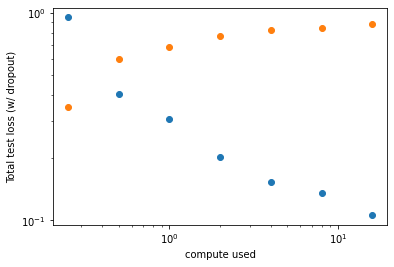

In [49]:
plt.scatter(d_compute_used, d_model_loss_params)
plt.scatter(d_compute_used, d_accuracy_params)

plt.xscale("log")
plt.xlabel("compute used")
plt.yscale("log")
plt.ylabel("Total test loss (w/ dropout)")
plt.show()

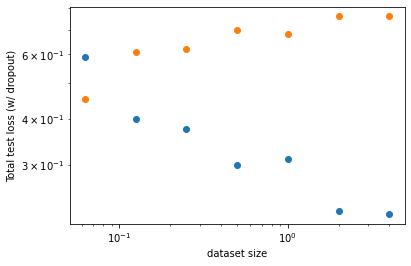

In [50]:
plt.scatter(d_dataset_size, d_model_loss_dataset)
plt.scatter(d_dataset_size, d_accuracy_dataset)

plt.xscale("log")
plt.xlabel("dataset size")
plt.yscale("log")
plt.ylabel("Total test loss (w/ dropout)")
plt.show()

In [54]:
dictData = {
    "dataset_size": d_dataset_size,
    "model_loss": d_model_loss_dataset,
    "accuracy": d_accuracy_dataset
}
dictCompute = {
    "compute used": d_compute_used,
    "model_loss": d_model_loss_params,
    "accuracy": d_accuracy_params
}

dataset_dropout = pd.DataFrame(dictData)
compute_dropout = pd.DataFrame(dictCompute)

In [ ]:
dataset_dropout.to_csv('dataset_scaling_with_dropout.csv')